# Predicting the approximate age of a person from photographs



Supermarket chain Good Seed is introducing a computer vision system for processing customer photos. Photofixation in the checkout area will help determine the age of customers in order to:

- Analyze purchases and offer products that may interest buyers in particular age groups
- Monitor clerks selling alcohol

Here we will build a model that will determine the approximate age of a person from a photograph. To help, we'll have a set of photographs of people with their ages indicated.

# 1. Exploratory data analysis

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [ ]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


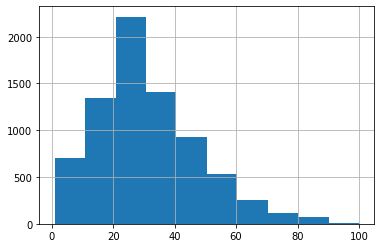

In [ ]:
labels['real_age'].hist()

In [ ]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [ ]:
features, target = next(train_gen_flow)

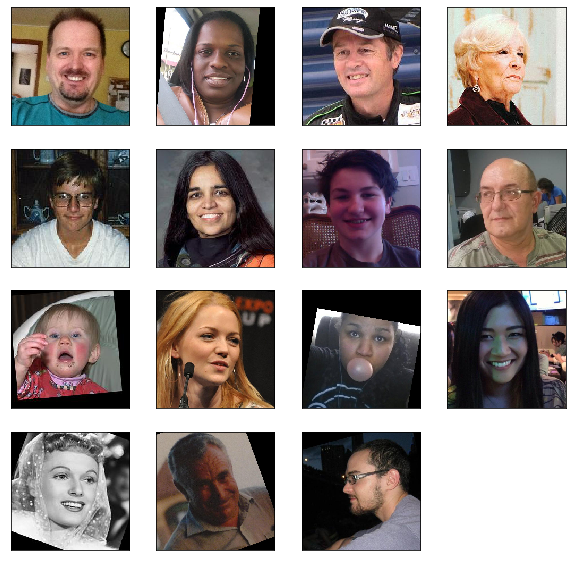

In [ ]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])

### Conclusion

The dataset has 7591 images of faces aged 1 to 100. The photos were taken in different lighting conditions, which have an effect on color. Some images are black and white, while others are in full color. The angles from which the faces were taken from also differ; some images are taken from the front while others are taken from the side. This might have an effect on the model training.

# 2. Model training

```python

import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

Train for 356 steps, validate for 119 steps

Epoch 1/20

2020-10-27 16:41:23.704592: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2020-10-27 16:41:28.162984: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

356/356 - 121s - loss: 223.5641 - mae: 10.8681 - val_loss: 405.4336 - val_mae: 15.0979

Epoch 2/20

356/356 - 42s - loss: 72.1533 - mae: 6.5273 - val_loss: 107.8051 - val_mae: 8.0023

Epoch 3/20

356/356 - 42s - loss: 38.9497 - mae: 4.8140 - val_loss: 77.2554 - val_mae: 6.6772

Epoch 4/20

356/356 - 42s - loss: 25.1567 - mae: 3.8682 - val_loss: 73.0438 - val_mae: 6.4144

Epoch 5/20

356/356 - 42s - loss: 16.8092 - mae: 3.1494 - val_loss: 71.5945 - val_mae: 6.4401

Epoch 6/20

356/356 - 43s - loss: 12.3424 - mae: 2.6932 - val_loss: 68.3969 - val_mae: 6.2122

Epoch 7/20

356/356 - 42s - loss: 10.9141 - mae: 2.5291 - val_loss: 67.0194 - val_mae: 6.2834

Epoch 8/20

356/356 - 42s - loss: 10.9324 - mae: 2.5272 - val_loss: 75.3248 - val_mae: 6.5329

Epoch 9/20

356/356 - 42s - loss: 10.6187 - mae: 2.4923 - val_loss: 69.3031 - val_mae: 6.3376

Epoch 10/20

356/356 - 42s - loss: 9.8374 - mae: 2.3816 - val_loss: 71.5554 - val_mae: 6.3241

Epoch 11/20

356/356 - 42s - loss: 9.9934 - mae: 2.4082 - val_loss: 77.8244 - val_mae: 6.7991

Epoch 12/20

356/356 - 42s - loss: 10.0908 - mae: 2.4060 - val_loss: 69.6952 - val_mae: 6.4151

Epoch 13/20

356/356 - 42s - loss: 9.4481 - mae: 2.3264 - val_loss: 68.7574 - val_mae: 6.2031

Epoch 14/20

356/356 - 42s - loss: 7.8666 - mae: 2.1217 - val_loss: 66.7710 - val_mae: 6.2478

Epoch 15/20

356/356 - 42s - loss: 7.1936 - mae: 2.0370 - val_loss: 67.6125 - val_mae: 6.1589

Epoch 16/20

356/356 - 42s - loss: 6.6753 - mae: 1.9724 - val_loss: 64.5257 - val_mae: 5.9834

Epoch 17/20

356/356 - 42s - loss: 6.9701 - mae: 2.0042 - val_loss: 68.8504 - val_mae: 6.1808

Epoch 18/20

356/356 - 43s - loss: 7.2843 - mae: 2.0554 - val_loss: 65.8756 - val_mae: 6.1666

Epoch 19/20

356/356 - 42s - loss: 7.0985 - mae: 2.0417 - val_loss: 66.3672 - val_mae: 6.1029

Epoch 20/20

356/356 - 42s - loss: 6.8441 - mae: 1.9833 - val_loss: 66.4497 - val_mae: 6.2451

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

119/119 - 10s - loss: 66.4497 - mae: 6.2451

Test MAE: 6.2451


```

# 3. Trained model analysis

The resulting test MAE is 6.2451. This was achieved at an Adam learning rate of 0.0001 and 20 epochs.